In [1]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from skimage import img_as_uint

from phase_opti import phase_registration_optim

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from stretchablecorr import *
import filetools as ft

cube, image_names = ft.load_image_sequence('./images/gris_E_x2')

In [47]:
window_half_size = 120
xy_center = 700, 600

In [48]:
A, xy0 = crop(cube[3], xy_center, window_half_size)
B, xy0 = crop(cube[4], xy_center, window_half_size)

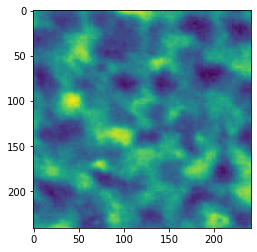

In [49]:
plt.imshow(A)

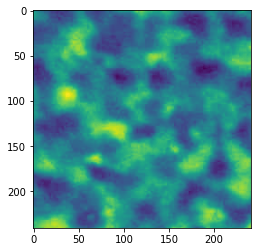

In [50]:
plt.imshow(B)

In [53]:
shift, hess_inv, res = phase_registration_optim(A, B, phase=True)
print(shift)

shift, _, _ = phase_cross_correlation(A, B, upsample_factor=20)
print(shift)

In [55]:
from phase_opti import fft_translate

In [56]:
#def compare(A, B, shift)
#shift = np.array([-1.74936478,  0.58937963])
#shift = np.array([-3.15,  0.55])
shift = shift
print(shift)
B_tr = fft_translate(B, *shift)
diff = (A - B_tr)**2
i_slicing = np.s_[max(0, int(np.ceil(shift[0]))):min(0, int(np.floor(shift[0])))-1]
j_slicing = np.s_[max(0, int(np.ceil(shift[1]))):min(0, int(np.floor(shift[1])))-1]

diff = diff[i_slicing, j_slicing]
print('==========')
print(f'{np.sum(diff):e}')

[5.55 4.4 ]
9.633297e+00


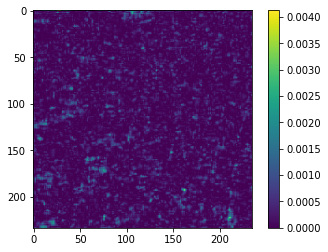

In [57]:
plt.imshow(diff); plt.colorbar();

In [58]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import fftn, ifftn
from scipy.fft import fftshift, fftfreq
from scipy.signal.windows import blackman

In [59]:
upsamplefactor=1
phase=True

if phase:
    u = blackman(A.shape[0])
    v = blackman(A.shape[1])
    window = u[:, np.newaxis] * v[np.newaxis, :]
else:
    window = 1

a, b = fftn(A * window), fftn(B * window)

ab = a * b.conj()
if phase:
    ab = ab / np.abs(ab)
phase_corr = ifftn(fftshift(ab),
                   s=upsamplefactor*np.array(ab.shape))
phase_corr = np.abs( fftshift(phase_corr) )

dx_span = fftshift( fftfreq(phase_corr.shape[1]) )*A.shape[1]
dy_span = fftshift( fftfreq(phase_corr.shape[0]) )*A.shape[0]

# argmax
argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
print(f"{argmax}")

def cost(xy, ab):
    return -np.abs(dft_tensordot(ab, xy))

def jac(xy, ab):
    return -np.real(grad_dft(ab, xy))

#res = minimize(cost, argmax, args=(ab, ), method='BFGS', tol=1e-3)#, jac=jac)
#return res.x, res.hess_inv, res
res

(8.0, 8.0)


      fun: -4172.795086982648
 hess_inv: array([[ 7.69513252e-05, -1.25595642e-05],
       [-1.25595642e-05,  1.08400679e-04]])
      jac: array([0.00012207, 0.        ])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([8.08249451, 8.09606115])

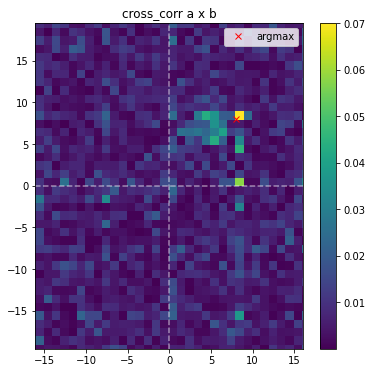

In [61]:
plt.figure(figsize=(6, 6))
#plt.pcolormesh(dx_span, dy_span, cross_corr, shading='flat');
plt.pcolormesh(dx_span, dy_span, phase_corr,
               shading='flat');
plt.axis('equal')
plt.title('cross_corr a x b'); plt.colorbar();


plt.plot(*argmax[::-1], 'xr', label='argmax');

plt.legend();plt.axvline(x=0, linestyle='--', color='white', alpha=0.5);
plt.axhline(y=0, linestyle='--', color='white', alpha=0.5);

dx, dy = 0, 0
zoom_factor = 15
plt.ylim([-A.shape[0]/zoom_factor - dy, +A.shape[0]/zoom_factor - dy ]);
plt.xlim([-A.shape[1]/zoom_factor - dx, +A.shape[1]/zoom_factor - dx]);


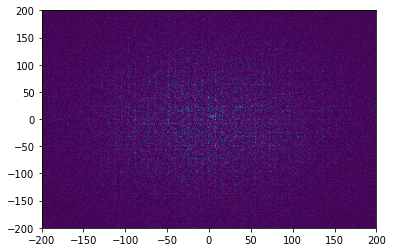

In [38]:
plt.pcolormesh(dx_span, dy_span, phase_corr)

In [ ]:
    # argmax
    argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
    argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
    #print(f"{argmax}")

    def cost(xy, ab):
        return -np.abs(dft_tensordot(ab, xy))

    def jac(xy, ab):
        return -np.real(grad_dft(ab, xy))

    res = minimize(cost, argmax, args=(ab, ), method='BFGS', tol=1e-3)#, jac=jac)
    return res.x, res.hess_inv, res